In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster       import KMeans

import math

import votinglib_funcs as vf
# self-defined library

from importlib import reload

# define threshold of popular support for major parties:
MAJ_PARTY_THRESH=0.05
WORKDIR = os.getcwd()
Vote_data_path = "./source_data/DL_BE_AB2016_V2_formatted.txt"

# What fraction of the dataset is used for training:
frac_train = 0.85

In [2]:
Data_RAW      = pd.read_csv( Vote_data_path, sep="\t", header=0 )
n_ridings     = Data_RAW.shape[0]
n_parties_all = Data_RAW.shape[1]-17

#Data_RAW.head
# print( Data_RAW.shape );  print( n_ridings ); print( n_parties_all )

In [3]:
# cross-check that the sum of all party votes adds up to the "valid" column
assert max(abs([sum( Data_RAW.values[n,17:]) for n in range(n_ridings) ] -  Data_RAW.values[:,16])) == 0
# first index corresponding to a party's vote tally is 17, continues in decreasing order of total votes.
party_names_all = Data_RAW.columns[17:]

print(party_names_all)

Index(['SPD', 'CDU', 'GRÜNE', 'LINKE', 'PIRATEN', 'NPD', 'FDP',
       'Tierschutzpartei', 'pro.Deutschland', 'DiePARTEI', 'BIG', 'DKP', 'ödp',
       'PSG', 'BüSo', 'B', 'DL', 'ALFA', 'Tierschutzallianz', 'AfD',
       'DIE.EINHEIT', 'DIE.VIOLETTEN', 'Graue.Panther', 'MENSCHLICHE.WELT',
       'MIETERPARTEI', 'Gesundheits.forschung'],
      dtype='object')


In [4]:
# separate ridings into "Urnen" (ballot box) Bezirks, and "Brief" (mail-in ballot) bezirks
Data_Urn   = Data_RAW.loc[ Data_RAW["Wahlbezirksart"] == "Urnenwahlbezirk" ]
Data_Brief = Data_RAW.loc[ Data_RAW["Wahlbezirksart"] == "Briefwahlbezirk" ]
# Old way of doing it: Data_Urn   = Data_RAW.set_index("Wahlbezirksart").loc["Urnenwahlbezirk"]

n_ridings_urn   = Data_Urn.shape[0]
n_ridings_brief = Data_Brief.shape[0]

print( n_ridings_urn )

# ====== we will work primarily with the "Urn" data (since there are many more of them)
# we'll come back to the Brief data later to check for robustness.

1779


In [5]:
major_parties, minor_parties = vf.get_major_minor_parties( Data_RAW.iloc[:,17:], MAJ_PARTY_THRESH )

n_parties_major = len(major_parties)

print( "Major parties : "); print( major_parties )
print( "Minor parties : "); print( minor_parties )

Major parties : 
['SPD', 'CDU', 'GRÜNE', 'LINKE', 'FDP', 'AfD']
Minor parties : 
['ALFA', 'B', 'BIG', 'BüSo', 'DIE.EINHEIT', 'DIE.VIOLETTEN', 'DKP', 'DL', 'DiePARTEI', 'Gesundheits.forschung', 'Graue.Panther', 'MENSCHLICHE.WELT', 'MIETERPARTEI', 'NPD', 'PIRATEN', 'PSG', 'Tierschutzallianz', 'Tierschutzpartei', 'pro.Deutschland', 'ödp']


In [6]:
# create a normalized table of normalized Vote shares amongst major parties (and an "Other" col.): 
VS_urn_all   = vf.get_normal_maj_VS( Data_Urn,   major_parties, minor_parties, add_other = True )
VS_brief_all = vf.get_normal_maj_VS( Data_Brief, major_parties, minor_parties, add_other = True )

# create numpy-array versions:
VS_urn_all_np      = VS_urn_all.values.copy()
VS_brief_all_np    = VS_brief_all.values.copy()

In [7]:
# isolate O-W lists for the classifier:
OW_urn        = Data_Urn["OstWest"].values
OW_urn_ints   = (OW_urn =="O").astype(int)
OW_brief      = Data_Brief["OstWest"].values
OW_brief_ints = (OW_brief =="O").astype(int)

# Get the mean positions of each of the groups
meanpoint_Ost  = np.mean( VS_urn_all.loc[ OW_urn =="O"  ] )
meanpoint_West = np.mean( VS_urn_all.loc[ OW_urn =="W"  ] )

# And define a vector pointint in the direction from one to the other.
OW_vec = (meanpoint_Ost - meanpoint_West)/np.linalg.norm( meanpoint_Ost - meanpoint_West ) 

# print (np.linalg.norm( OW_vec ))

In [8]:
party_list = major_parties + ["Other"]
print( party_list )

['SPD', 'CDU', 'GRÜNE', 'LINKE', 'FDP', 'AfD', 'Other']


In [9]:
# =============================================================================================
# Preliminary plots:    
# =============================================================================================

In [10]:
reload(vf)

<module 'votinglib_funcs' from '/Users/lana/Documents/projects/voting_patterns/calculations/votinglib_funcs.py'>

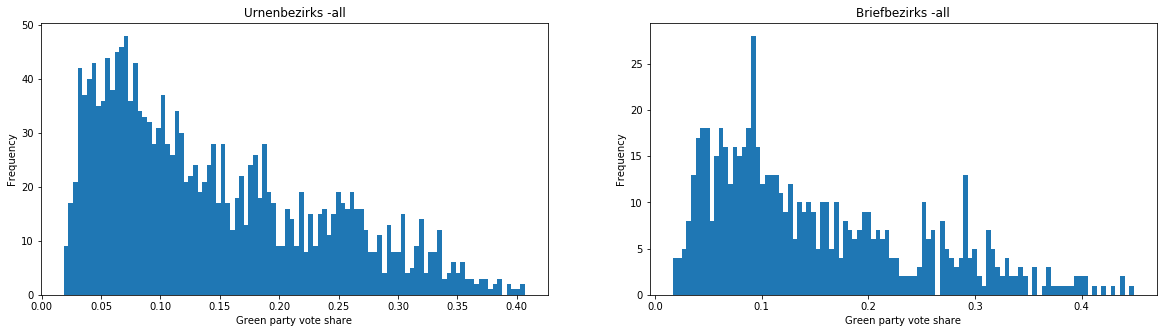

In [11]:
plt.rcParams['figure.figsize'] = [20, 5]
fig, (p1, p2) = plt.subplots(1, 2)

p1.hist( VS_urn_all ["GRÜNE"], 
         bins = 100)
p1.set( xlabel = "Green party vote share", 
        ylabel =  "Frequency", 
        title  = "Urnenbezirks -all")

p2.hist( VS_brief_all ["GRÜNE"], 
         bins = 100)
p2.set( xlabel = "Green party vote share", 
        ylabel =  "Frequency", 
        title  = "Briefbezirks -all")

plt.savefig("images/Green_support_hist")

In [12]:
pca  = PCA()
VS_urn_all_np_PC   = pca.fit_transform( VS_urn_all_np  )
VS_brief_all_np_PC = pca.fit_transform( VS_brief_all_np )

# confirm that absdiffs are unchanged
# print( vf.normdiff_nparrays ( VS_urn_all_np ,    52 , 21) )
# print( vf.normdiff_nparrays ( VS_urn_all_np_PC , 52 , 21) )

In [13]:
DS_urn   = vf.model_dataset( Data_all   = VS_urn_all,
                             target     = OW_urn_ints,
                             party_list = party_list,
                             frac_train = frac_train,
                             rngSEED    = 42
                            )
DS_brief = vf.model_dataset( Data_all   = VS_brief_all,
                             target     = OW_brief_ints,
                             party_list = party_list,
                             frac_train = frac_train,
                             rngSEED    = 42
                            )

In [14]:
DS_urn.train_dat.values

array([[0.20771513, 0.22057369, 0.20178042, ..., 0.09792285, 0.13353116,
        0.07319486],
       [0.17916137, 0.39135959, 0.12579416, ..., 0.1321474 , 0.08259212,
        0.05463787],
       [0.27860697, 0.15754561, 0.11111111, ..., 0.08623549, 0.16086235,
        0.11774461],
       ...,
       [0.21960784, 0.13137255, 0.1627451 , ..., 0.04705882, 0.09803922,
        0.11568627],
       [0.25651303, 0.29058116, 0.11022044, ..., 0.07014028, 0.15230461,
        0.06212425],
       [0.15776398, 0.07950311, 0.03478261, ..., 0.02111801, 0.30062112,
        0.19006211]])

[Text(0, 0.5, 'PC2'), Text(0.5, 0, 'PC1'), Text(0.5, 1.0, 'PC-rotation')]

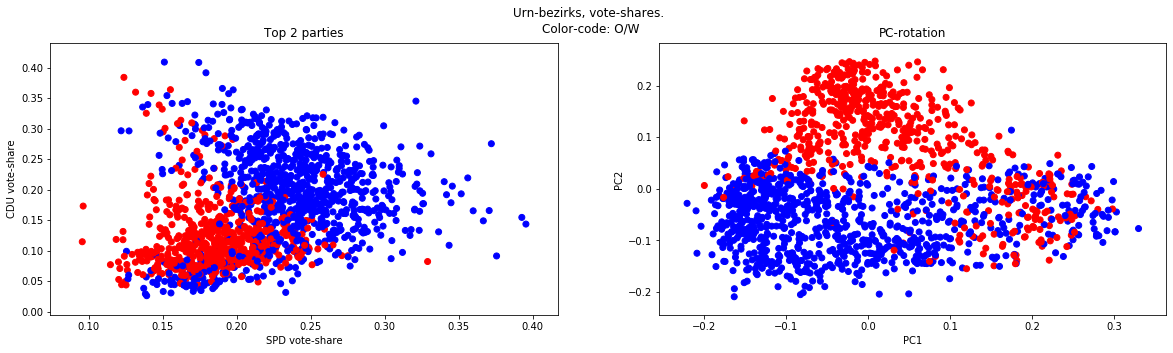

In [15]:
plt.rcParams['figure.figsize'] = [20, 5]
fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Urn-bezirks, vote-shares. \nColor-code: O/W')

p1.scatter( DS_urn.train_dat.values[:, 0], 
            DS_urn.train_dat.values[:, 1],
            c  = DS_urn.train_ccode["OW"] );
p1.set( xlabel = party_list[0]  + ' vote-share', 
        ylabel = party_list[1] + ' vote-share', 
        title  = "Top 2 parties")

p2.scatter( DS_urn.train_dat_PCA[:, 0], 
            DS_urn.train_dat_PCA[:, 1],
            c= DS_urn.train_ccode["OW"] );
p2.set(xlabel= 'PC1', ylabel='PC2', title="PC-rotation")

[Text(0, 0.5, 'PC2'), Text(0.5, 0, 'PC1'), Text(0.5, 1.0, 'PC-rotation')]

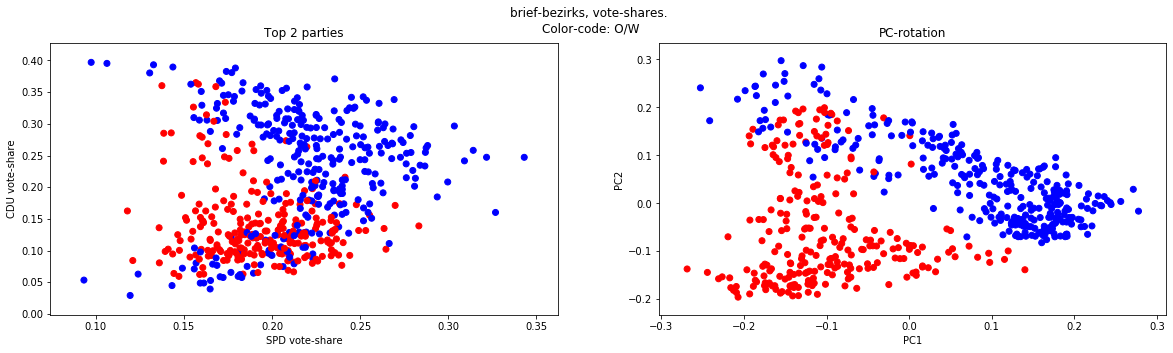

In [16]:
plt.rcParams['figure.figsize'] = [20, 5]
fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('brief-bezirks, vote-shares. \nColor-code: O/W')

p1.scatter( DS_brief.train_dat.values[:, 0], 
            DS_brief.train_dat.values[:, 1],
            c  = DS_brief.train_ccode["OW"] );
p1.set( xlabel = party_list[0]  + ' vote-share', 
        ylabel = party_list[1] + ' vote-share', 
        title  = "Top 2 parties")

p2.scatter( DS_brief.train_dat_PCA[:, 0], 
            DS_brief.train_dat_PCA[:, 1],
            c= DS_brief.train_ccode["OW"] );
p2.set(xlabel= 'PC1', ylabel='PC2', title="PC-rotation")

[Text(0, 0.5, 'PC2'), Text(0.5, 0, 'PC1'), Text(0.5, 1.0, 'PC-rotation')]

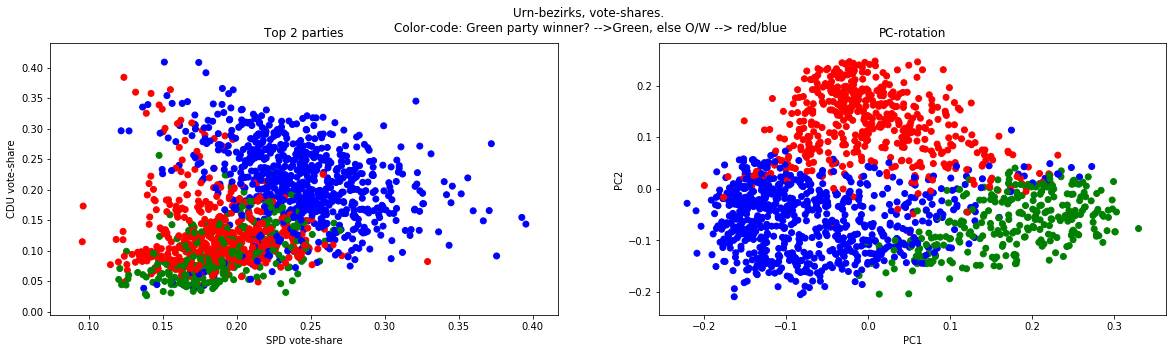

In [17]:
plt.rcParams['figure.figsize'] = [20, 5]
fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Urn-bezirks, vote-shares. \nColor-code: Green party winner? -->Green, else O/W --> red/blue')

p1.scatter( DS_urn.train_dat.values[:, 0], 
            DS_urn.train_dat.values[:, 1],
            c = DS_urn.train_ccode["Gwinner_OW"] );
p1.set( xlabel = party_list[0]  + ' vote-share', 
        ylabel = party_list[1] + ' vote-share', 
        title  = "Top 2 parties")

p2.scatter( DS_urn.train_dat_PCA[:, 0], 
            DS_urn.train_dat_PCA[:, 1],
            c= DS_urn.train_ccode["Gwinner_OW"] );
p2.set(xlabel= 'PC1', ylabel='PC2', title="PC-rotation")

[Text(0, 0.5, 'PC2'), Text(0.5, 0, 'PC1'), Text(0.5, 1.0, 'PC-rotation')]

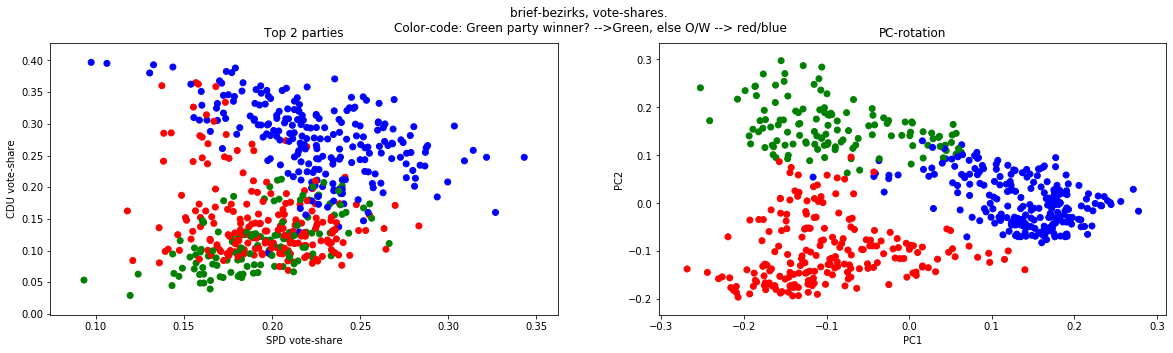

In [18]:
plt.rcParams['figure.figsize'] = [20, 5]
fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('brief-bezirks, vote-shares. \nColor-code: Green party winner? -->Green, else O/W --> red/blue')

p1.scatter( DS_brief.train_dat.values[:, 0], 
            DS_brief.train_dat.values[:, 1],
            c = DS_brief.train_ccode["Gwinner_OW"] );
p1.set( xlabel = party_list[0]  + ' vote-share', 
        ylabel = party_list[1] + ' vote-share', 
        title  = "Top 2 parties")

p2.scatter( DS_brief.train_dat_PCA[:, 0], 
            DS_brief.train_dat_PCA[:, 1],
            c= DS_brief.train_ccode["Gwinner_OW"] );
p2.set(xlabel= 'PC1', ylabel='PC2', title="PC-rotation")

In [19]:
clustercode_2, percW_2 = vf.cleanclusters( 2, VS_urn_all, OW_urn )
clustercode_3, percW_3 = vf.cleanclusters( 3, VS_urn_all, OW_urn )

C0_urn =  VS_urn_all.values[ clustercode_3 == 0, :]
C1_urn =  VS_urn_all.values[ clustercode_3 == 1, :]
C2_urn =  VS_urn_all.values[ clustercode_3 == 2, :]

print(C0_urn.shape)
print(C1_urn.shape)
print(C2_urn.shape)
print( percW_3)


(780, 7)
(507, 7)
(492, 7)
[0.9423076923076923, 0.6410256410256411, 0.03048780487804878]


In [20]:
DU_rot_OW  = vf.rotate_data_along_vec_PCs( DS_urn.train_dat.values, OW_vec     )
# DU_rot_C01 = vf.rotate_data_along_vec_PCs( VS_urn_all.values, C01_normed )
# DU_rot_C02 = vf.rotate_data_along_vec_PCs( VS_urn_all.values, C02_normed )
# Sanity check:
# m,n = np.random.randint(1,1778,2)
# print( dist(D2[m,:],  D2[n,:] ) - dist(Dat[m,:], Dat[n,:]) )

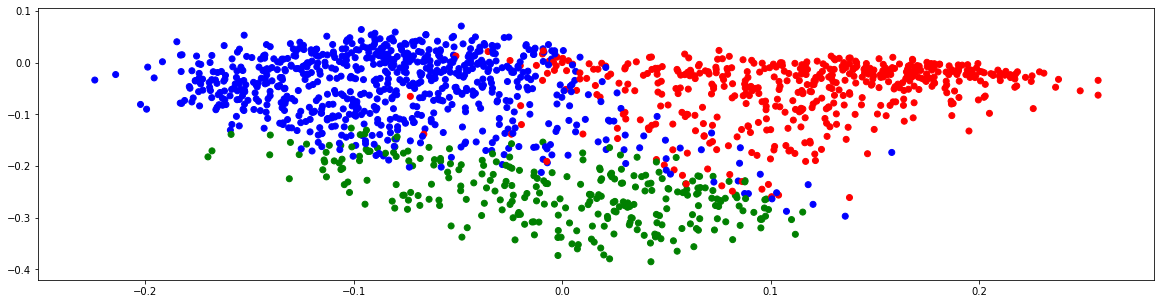

In [21]:
# plt.rcParams['figure.figsize'] = [20, 5]
# fig, (p1, p2) = plt.subplots(1, 2)

plt.scatter( DU_rot_OW[:,0], 
            DU_rot_OW[:,2],
            c = DS_urn.train_ccode["Gwinner_OW"] )

In [75]:
# ====================================================================
# Now introduce classifiers:
# ====================================================================
reload(vf)

<module 'votinglib_funcs' from '/Users/lana/Documents/projects/voting_patterns/calculations/votinglib_funcs.py'>

In [22]:
VS_urn_Gnotwinner, OWlist_urn_Gnotwinner_ints  = vf.filter_winner( VS_urn_all, 
                                                               OW_list     = OW_urn_ints, 
                                                               party_list  = party_list,
                                                               filterparty = "GRÜNE" )

In [23]:
VS_brief_Gnotwinner, OWlist_brief_Gnotwinner_ints  = vf.filter_winner( VS_brief_all, 
                                                                 OW_list     = OW_brief_ints, 
                                                                 party_list  = party_list,
                                                                 filterparty = "GRÜNE" )

In [24]:
VS_urn_Gnotwinner.shape

(1453, 7)

In [26]:
 OWlist_urn_Gnotwinner_ints.shape

(1453,)

In [27]:
#-------------------------------
# Now without the Green winners:
DS_urn_Gnotwinner   = vf.model_dataset( Data_all   = VS_urn_Gnotwinner,
                                        target     = OWlist_urn_Gnotwinner_ints,
                                        party_list = party_list,
                                        frac_train = frac_train,
                                        rngSEED    = 42
                                      )

In [29]:
DS_brief_Gnotwinner   = vf.model_dataset( Data_all   = VS_brief_Gnotwinner,
                                          target     = OWlist_brief_Gnotwinner_ints,
                                          party_list = party_list,
                                          frac_train = frac_train,
                                          rngSEED    = 42
                                         )

In [43]:
#start with SGD:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix

sgd_clf = SGDClassifier( max_iter=5, 
                         tol=-np.infty, 
                         random_state=7)
sgd_clf.fit( DS_urn.train_dat, DS_urn.train_y )
predicted             = sgd_clf.predict( DS_urn.test_dat)
predicted_correctly   = predicted == DS_urn.test_y

print("----------- \nAccuracy predicting O/W on Urn test data with SGD:")
print( sum( predicted_correctly.astype(int))/len(predicted) ) 
print( confusion_matrix( predicted, DS_urn.test_y ) )

print("----------- \nAccuracy predicting O/W on Brief test data trained with urn-data SGD:")
predicted = sgd_clf.predict( DS_brief.test_dat)
predicted_correctly   = ( predicted == DS_brief.test_y )
print( sum( predicted_correctly.astype(int))/len(predicted) ) 
print( confusion_matrix( predicted, DS_brief.test_y ) )


----------- 
Accuracy predicting O/W on Urn test data with SGD:
0.8614232209737828
[[132   5]
 [ 32  98]]
----------- 
Accuracy predicting O/W on Brief test data trained with urn-data SGD:
0.9387755102040817
[[56  3]
 [ 3 36]]


In [44]:
# Now try RF:
from sklearn.ensemble import RandomForestClassifier

forest_clf    = RandomForestClassifier( n_estimators=100, 
                                        random_state=42)

forest_clf.fit( DS_urn.train_dat, DS_urn.train_y )
# forest_scores = cross_val_score( forest_clf, 
#                                  X_train, 
#                                  y_train, 
#                                  cv=10)
# forest_scores.mean()

predicted             = forest_clf.predict( DS_urn.test_dat)
predicted_correctly   = predicted == DS_urn.test_y

print("----------- \nAccuracy predicting O/W on Urn test data with SGD:")
print( sum( predicted_correctly.astype(int))/len(predicted) ) 
print( confusion_matrix( predicted, DS_urn.test_y ) )

print("----------- \nAccuracy predicting O/W on Brief test data trained with urn-data SGD:")
predicted = forest_clf.predict( DS_brief.test_dat)
predicted_correctly   = ( predicted == DS_brief.test_y )
print( sum( predicted_correctly.astype(int))/len(predicted) ) 
print( confusion_matrix( predicted, DS_brief.test_y ) )

# forest_clf_GNW = SGDClassifier( max_iter=5, 
#                              tol=-np.infty, 
#                              random_state=7)
# forest_clf.fit( DS_urn_Gnotwinner.train_dat, DS_urn_Gnotwinner.train_y )

# predicted             = forest_clf.predict(DS_urn_Gnotwinner.test_dat)
# predicted_correctly   = predicted == DS_urn_Gnotwinner.test_y

# print("----------- \nAccuracy predicting O/W with G-winners removed:")
# print( sum( predicted_correctly.astype(int))/len(predicted) ) 

----------- 
Accuracy predicting O/W on Urn test data with SGD:
0.9101123595505618
[[149   9]
 [ 15  94]]
----------- 
Accuracy predicting O/W on Brief test data trained with urn-data SGD:
0.9591836734693877
[[58  3]
 [ 1 36]]


In [45]:
# Try without the green cluster:

forest_clf    = RandomForestClassifier( n_estimators=100, 
                                        random_state=42)

forest_clf.fit( DS_urn_Gnotwinner.train_dat, DS_urn_Gnotwinner.train_y )
# forest_scores = cross_val_score( forest_clf, 
#                                  X_train, 
#                                  y_train, 
#                                  cv=10)
# forest_scores.mean()

predicted             = forest_clf.predict( DS_urn_Gnotwinner.test_dat)
predicted_correctly   = predicted == DS_urn_Gnotwinner.test_y

print("----------- \nAccuracy predicting O/W on Urn test data with SGD:")
print( sum( predicted_correctly.astype(int))/len(predicted) ) 
print( confusion_matrix( predicted, DS_urn_Gnotwinner.test_y ) )

print("----------- \nAccuracy predicting O/W on Brief test data trained with urn-data SGD:")
predicted = forest_clf.predict( DS_brief_Gnotwinner.test_dat)
predicted_correctly   = ( predicted == DS_brief_Gnotwinner.test_y )
print( sum( predicted_correctly.astype(int))/len(predicted) ) 
print( confusion_matrix( predicted, DS_brief_Gnotwinner.test_y ) )


----------- 
Accuracy predicting O/W on Urn test data with SGD:
0.9724770642201835
[[127   3]
 [  3  85]]
----------- 
Accuracy predicting O/W on Brief test data trained with urn-data SGD:
0.9871794871794872
[[40  1]
 [ 0 37]]


In [46]:
# SVC:
from sklearn.svm import SVC
svm_l_clf = SVC(kernel="linear", C=float("inf"))

svm_l_clf.fit( DS_urn.train_dat, DS_urn.train_y )



def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

In [51]:
svm_l_clf.support_vectors_.shape

(192, 7)

In [55]:
len(DS_urn.train_y[DS_urn.train_y==0])

911

In [49]:
predicted = svm_l_clf.predict( DS_urn.test_dat)
predicted


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])